# Вебинар 6. Консультация по курсовому проекту.

### Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу NVBaranov_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (названия колонок + 5000 предсказаний).

Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение любых моделей машинного обучения из библиотеки sklearn.

### Прогнозирование на тестовом датасете

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков (лучше выполнять действия сразу для двух датасетов)
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

**Подключение библиотек и скриптов**

In [17]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
matplotlib.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)

In [20]:
def evaluate_preds(train_true_values, train_pred_values, val_true_values, val_pred_values):
    """
    Функция для оценки работы модели
    Parameters:
    train_true_values - целевая переменная из тренировочной части датасета
    train_pred_values - предсказания модели по тренировочной части
    val_true_values - целевая переменная из валидационной части датасета
    val_pred_values - предсказания модели по валидационной части
    Returns:
    R2 на тренировочной и валидационной части, 
    графики зависимости истинных значений от предсказаний
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Valid R2:\t" + str(round(r2(val_true_values, val_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=val_pred_values, y=val_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    plt.show()

**Пути к директориям и файлам**

In [21]:
TRAIN_DATASET_PATH = '/Users/apple/Documents/train.csv'
TEST_DATASET_PATH = '/Users/apple/Documents/test.csv'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [22]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
display(train_df.tail())
print(train_df.shape)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.402,30.476,5.0,6,5.0,1968,0.136,B,B,46,7960,6,350.0,3,11,B,196684.316
9996,6159,18,1.0,41.522,20.539,9.0,13,13.0,2000,0.000,B,B,30,5562,0,NaN,0,5,A,189050.290
9997,5123,27,1.0,47.939,NaN,1.0,12,16.0,2015,0.072,B,B,2,629,1,NaN,0,0,A,159143.805
9998,5400,75,2.0,43.603,33.840,8.0,1,5.0,1961,0.307,B,A,30,5048,9,325.0,2,5,B,181595.340
9999,6306,128,1.0,38.667,21.158,8.0,7,17.0,1990,0.000,B,B,27,4798,0,30.0,2,8,B,218714.078


(10000, 20)


In [23]:
# plt.scatter(x=train_df['HouseFloor'], y=train_df['Price']);
# df_num_features = test_df.select_dtypes(include='float64')
# sns.pairplot(df_num_features)

In [24]:
# train_df = train_df.set_index('Id')
# test_df = test_df.set_index('Id')
display(train_df.tail())
# print(test_df.shape)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.402,30.476,5.0,6,5.0,1968,0.136,B,B,46,7960,6,350.0,3,11,B,196684.316
9996,6159,18,1.0,41.522,20.539,9.0,13,13.0,2000,0.000,B,B,30,5562,0,NaN,0,5,A,189050.290
9997,5123,27,1.0,47.939,NaN,1.0,12,16.0,2015,0.072,B,B,2,629,1,NaN,0,0,A,159143.805
9998,5400,75,2.0,43.603,33.840,8.0,1,5.0,1961,0.307,B,A,30,5048,9,325.0,2,5,B,181595.340
9999,6306,128,1.0,38.667,21.158,8.0,7,17.0,1990,0.000,B,B,27,4798,0,30.0,2,8,B,218714.078


In [25]:
test_df = pd.read_csv(TEST_DATASET_PATH)
train_df.shape[1]-1 == test_df.shape[1]

True

In [26]:
test_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

### Приведение типов

In [27]:
train_df.dtypes
print(train_df.shape)

(10000, 20)


In [28]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

test_df['Id'] = test_df['Id'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

### Обзор данных

**Целевая переменная**

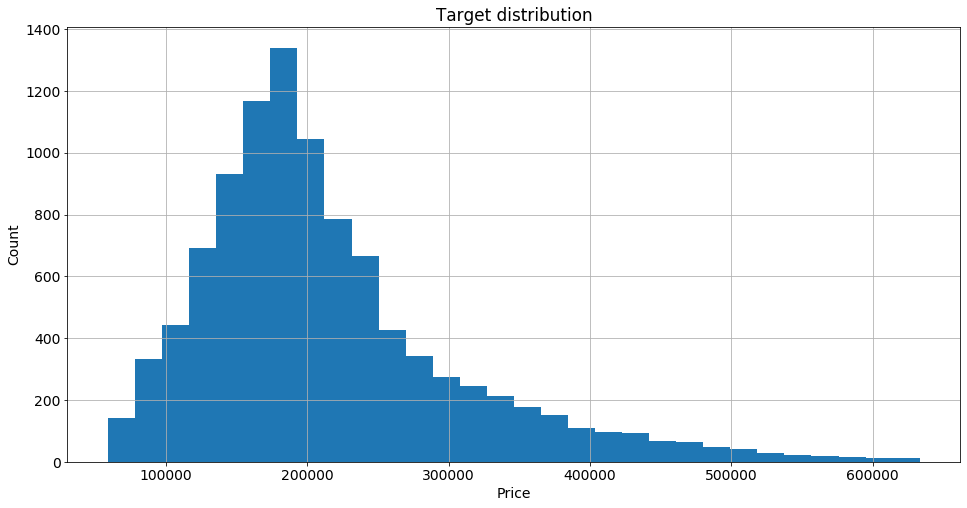

In [29]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution')
plt.show()

**Количественные переменные**

In [30]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.0,1.891,0.840,0.000,1.000,2.000,2.000,1.900e+01
Square,10000.0,56.316,21.059,1.137,41.775,52.513,65.901,6.411e+02
LifeSquare,7887.0,37.200,86.241,0.371,22.770,32.781,45.129,7.481e+03
KitchenSquare,10000.0,6.273,28.561,0.000,1.000,6.000,9.000,2.014e+03
Floor,10000.0,8.527,5.241,1.000,4.000,7.000,12.000,4.200e+01
HouseFloor,10000.0,12.609,6.776,0.000,9.000,13.000,17.000,1.170e+02
HouseYear,10000.0,3990.166,200500.261,1910.000,1974.000,1977.000,2001.000,2.005e+07
Ecology_1,10000.0,0.119,0.119,0.000,0.018,0.075,0.196,5.219e-01
Social_1,10000.0,24.687,17.533,0.000,6.000,25.000,36.000,7.400e+01
Social_2,10000.0,5352.157,4006.800,168.000,1564.000,5285.000,7227.000,1.908e+04


In [31]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,5000.0,1.910,0.839,0.000,1.000,2.000,2.000,17.000
Square,5000.0,56.450,19.093,1.379,41.906,52.921,66.285,223.454
LifeSquare,3959.0,36.159,17.825,0.333,23.092,32.925,45.174,303.071
KitchenSquare,5000.0,5.977,9.950,0.000,1.000,6.000,9.000,620.000
Floor,5000.0,8.632,5.483,1.000,4.000,7.000,12.000,78.000
HouseFloor,5000.0,12.601,6.789,0.000,9.000,12.000,17.000,99.000
HouseYear,5000.0,1984.393,18.573,1908.000,1973.000,1977.000,2000.000,2020.000
Ecology_1,5000.0,0.120,0.120,0.000,0.020,0.072,0.196,0.522
Social_1,5000.0,24.934,17.532,0.000,6.000,25.000,36.000,74.000
Social_2,5000.0,5406.900,4026.615,168.000,1564.000,5285.000,7287.000,19083.000


**Категориальные переменные**

In [32]:
cat_colnames = train_df.select_dtypes(include='object').columns.tolist()
cat_colnames

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [33]:
for cat_colname in cat_colnames[2:]:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64
****************************************************************************************************



### Обработка выбросов

**Rooms**

In [34]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [35]:
test_df['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64

In [36]:
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = train_df['Rooms'].median()
train_df.shape

(10000, 20)

In [37]:
test_df.loc[test_df['Rooms'].isin([0, 17]), 'Rooms'] = test_df['Rooms'].median()
test_df.shape

(5000, 19)

**Square, LifeSquare, KitchenSquare**

In [38]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000,10000.000,7887.000,10000.000,10000.000,10000.000,1.000e+04,10000.000,10000.000,10000.000,10000.000,5202.000,10000.000,10000.000,10000.000
mean,1.889,56.316,37.200,6.273,8.527,12.609,3.990e+03,0.119,24.687,5352.157,8.039,1142.904,1.319,4.231,214138.857
std,0.812,21.059,86.241,28.561,5.241,6.776,2.005e+05,0.119,17.533,4006.800,23.832,1021.517,1.494,4.806,92872.294
min,1.000,1.137,0.371,0.000,1.000,0.000,1.910e+03,0.000,0.000,168.000,0.000,0.000,0.000,0.000,59174.778
25%,1.000,41.775,22.770,1.000,4.000,9.000,1.974e+03,0.018,6.000,1564.000,0.000,350.000,0.000,1.000,153872.634
50%,2.000,52.513,32.781,6.000,7.000,13.000,1.977e+03,0.075,25.000,5285.000,2.000,900.000,1.000,3.000,192269.645
75%,2.000,65.901,45.129,9.000,12.000,17.000,2.001e+03,0.196,36.000,7227.000,5.000,1548.000,2.000,6.000,249135.462
max,6.000,641.065,7480.592,2014.000,42.000,117.000,2.005e+07,0.522,74.000,19083.000,141.000,4849.000,6.000,23.000,633233.467


In [39]:
# обработка пропусков, выбросов KitchenSquare, LifeSquare, Healthcare_1

train_df.loc[train_df['KitchenSquare'] == 0, 'KitchenSquare'] = train_df['KitchenSquare'].median()
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = train_df['LifeSquare'].median()
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()
train_df.shape

(10000, 20)

In [40]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,5000.0,1.908,0.810,1.000,1.000,2.000,2.000,6.000
Square,5000.0,56.450,19.093,1.379,41.906,52.921,66.285,223.454
LifeSquare,3959.0,36.159,17.825,0.333,23.092,32.925,45.174,303.071
KitchenSquare,5000.0,5.977,9.950,0.000,1.000,6.000,9.000,620.000
Floor,5000.0,8.632,5.483,1.000,4.000,7.000,12.000,78.000
HouseFloor,5000.0,12.601,6.789,0.000,9.000,12.000,17.000,99.000
HouseYear,5000.0,1984.393,18.573,1908.000,1973.000,1977.000,2000.000,2020.000
Ecology_1,5000.0,0.120,0.120,0.000,0.020,0.072,0.196,0.522
Social_1,5000.0,24.934,17.532,0.000,6.000,25.000,36.000,74.000
Social_2,5000.0,5406.900,4026.615,168.000,1564.000,5285.000,7287.000,19083.000


In [41]:
# обработка пропусков, выбросов KitchenSquare, LifeSquare
test_df.loc[test_df['KitchenSquare'] == 0, 'KitchenSquare'] = train_df['KitchenSquare'].median()
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = train_df['LifeSquare'].median()
test_df.shape

(5000, 19)

In [42]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.0,1.889,0.812,1.000,1.000,2.000,2.000,6.000e+00
Square,10000.0,56.316,21.059,1.137,41.775,52.513,65.901,6.411e+02
LifeSquare,10000.0,36.266,76.610,0.371,25.527,32.781,41.427,7.481e+03
KitchenSquare,10000.0,6.691,28.510,1.000,4.000,6.000,9.000,2.014e+03
Floor,10000.0,8.527,5.241,1.000,4.000,7.000,12.000,4.200e+01
HouseFloor,10000.0,12.609,6.776,0.000,9.000,13.000,17.000,1.170e+02
HouseYear,10000.0,3990.166,200500.261,1910.000,1974.000,1977.000,2001.000,2.005e+07
Ecology_1,10000.0,0.119,0.119,0.000,0.018,0.075,0.196,5.219e-01
Social_1,10000.0,24.687,17.533,0.000,6.000,25.000,36.000,7.400e+01
Social_2,10000.0,5352.157,4006.800,168.000,1564.000,5285.000,7227.000,1.908e+04


In [43]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,5000.0,1.908,0.810,1.000,1.000,2.000,2.000,6.000
Square,5000.0,56.450,19.093,1.379,41.906,52.921,66.285,223.454
LifeSquare,5000.0,35.456,15.920,0.333,25.850,32.781,41.770,303.071
KitchenSquare,5000.0,6.379,9.821,1.000,5.000,6.000,9.000,620.000
Floor,5000.0,8.632,5.483,1.000,4.000,7.000,12.000,78.000
HouseFloor,5000.0,12.601,6.789,0.000,9.000,12.000,17.000,99.000
HouseYear,5000.0,1984.393,18.573,1908.000,1973.000,1977.000,2000.000,2020.000
Ecology_1,5000.0,0.120,0.120,0.000,0.020,0.072,0.196,0.522
Social_1,5000.0,24.934,17.532,0.000,6.000,25.000,36.000,74.000
Social_2,5000.0,5406.900,4026.615,168.000,1564.000,5285.000,7287.000,19083.000


**HouseFloor, Floor**

In [44]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [45]:
train_df['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [46]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020
train_df['HouseYear'].sort_values().unique()

array([1910, 1912, 1914, 1916, 1917, 1918, 1919, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942,
       1947, 1948, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [47]:
test_df['HouseYear'].sort_values().unique()

array([1908, 1909, 1910, 1911, 1912, 1914, 1917, 1918, 1920, 1926, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1937, 1938, 1939,
       1940, 1941, 1943, 1948, 1949, 1950, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

### Обработка пропусков

In [48]:
train_df.isnull().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

In [49]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(7)

,Square,LifeSquare,KitchenSquare
0,47.982,29.443,6.0
1,65.684,40.050,8.0
2,44.948,29.198,6.0
3,53.353,52.732,9.0
4,39.649,23.776,7.0
5,80.384,46.684,12.0
6,62.254,37.160,7.0


**Healthcare_1**

In [50]:
train_df['Healthcare_1'].head()

0     900.0
1     240.0
2     229.0
3    1084.0
4    2078.0
Name: Healthcare_1, dtype: float64

In [51]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

### Построение новых признаков

**Dummies**

In [52]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

**DistrictSize, IsDistrictLarge**

In [53]:
train_df['DistrictId'].value_counts()
train_df.shape

(10000, 23)

In [54]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})


In [55]:
print(train_df.shape)
print(test_df.shape)

(10000, 23)
(5000, 22)


### Отбор признаков

In [56]:
train_df.columns.tolist()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
Id               10000 non-null object
DistrictId       10000 non-null object
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     10000 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
Ecology_2_bin    10000 non-null int64
Ecology_3_bin    10000 non-null int64
Shops_2_bin      10000 non-null int

In [57]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']

# new_feature_names = ['IsDistrictLarge', 'MedPriceByDistrict']

target_name = 'Price'

### Разбиение на train и val

In [58]:
X = train_df[feature_names] # + new_feature_names]
y = train_df[target_name]

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### Построение модели

**Обучение и оценка модели**

In [60]:
rf_model = RandomForestRegressor(random_state=21)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=21, verbose=0,
                      warm_start=False)

**Отложенная выборка**

Train R2:	0.946
Valid R2:	0.691


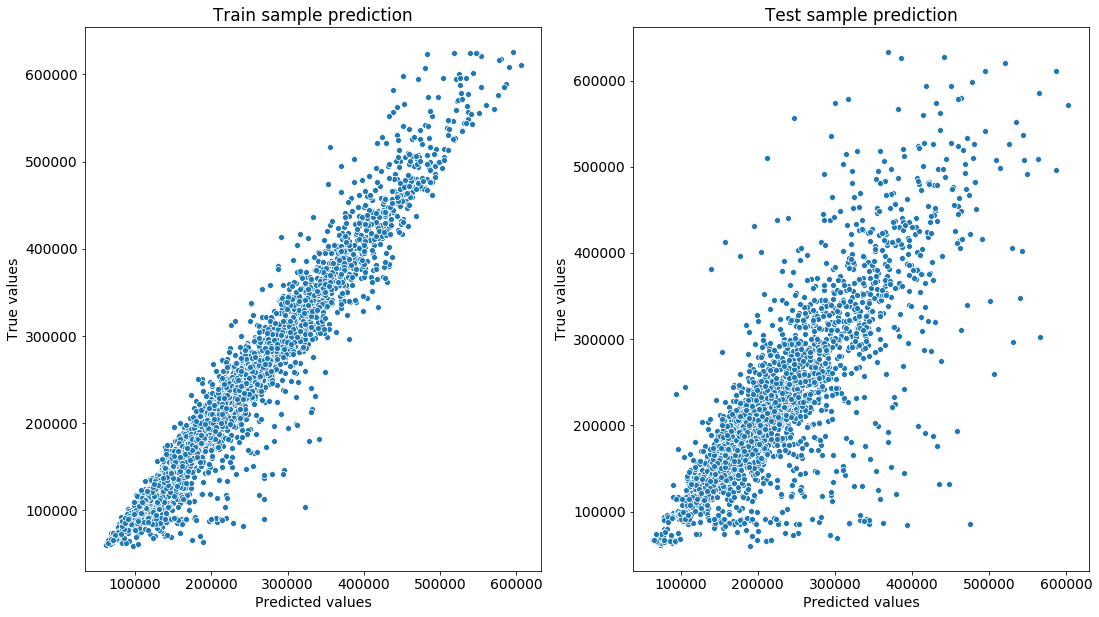

In [61]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

**Перекрёстная проверка**

In [62]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.70097559, 0.68828027, 0.70059004])

In [63]:
cv_score.mean()

0.696615300566887

### XGBoost

Train R2:	0.99
Valid R2:	0.728


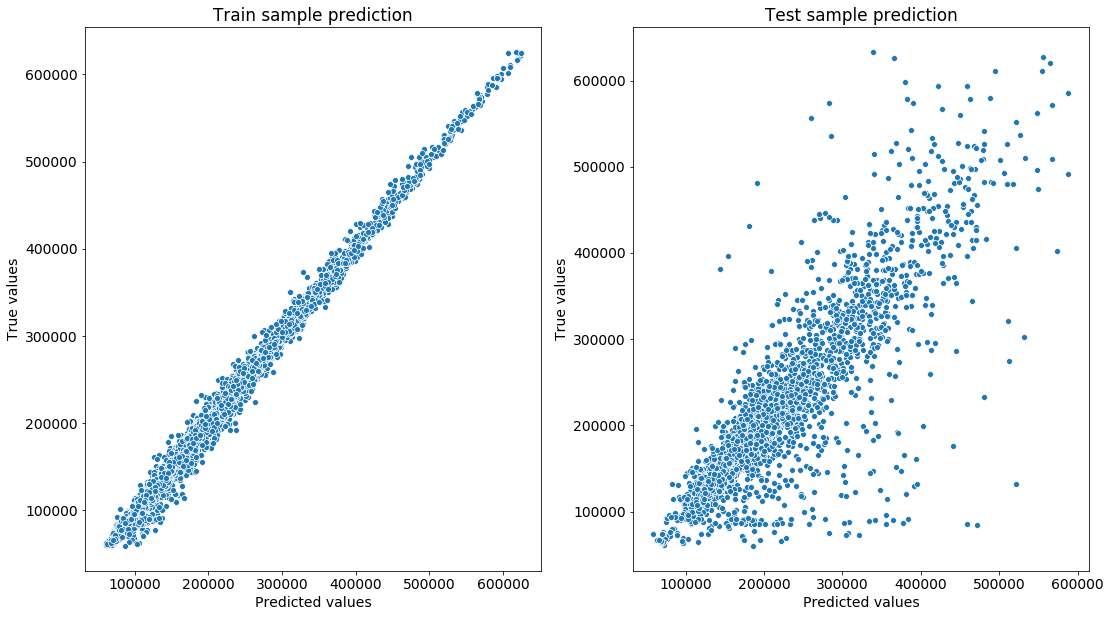

In [64]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=500, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7, objective ='reg:squarederror')
xgb.fit(X_train, y_train)

y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [65]:
from sklearn.metrics import r2_score

In [66]:
# A parameter grid for XGBoost
params = {'min_child_weight':[4,5], 
          'gamma':[i/10.0 for i in range(3,6)],  
          'subsample':[i/10.0 for i in range(6,11)],
          'max_depth': [2,3,4,7]}

# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=-1, objective ='reg:squarederror') 

grid = GridSearchCV(xgb, params)
grid.fit(X_train,y_train) 

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=-1,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'gamma': [0.3, 0.4, 0.5], 'max_depth': [2, 3, 4, 7],
                         'min_child

In [67]:
print(r2_score(y_test, grid.best_estimator_.predict(X_test)))

0.7242729920926824


Train R2:	0.912
Valid R2:	0.724


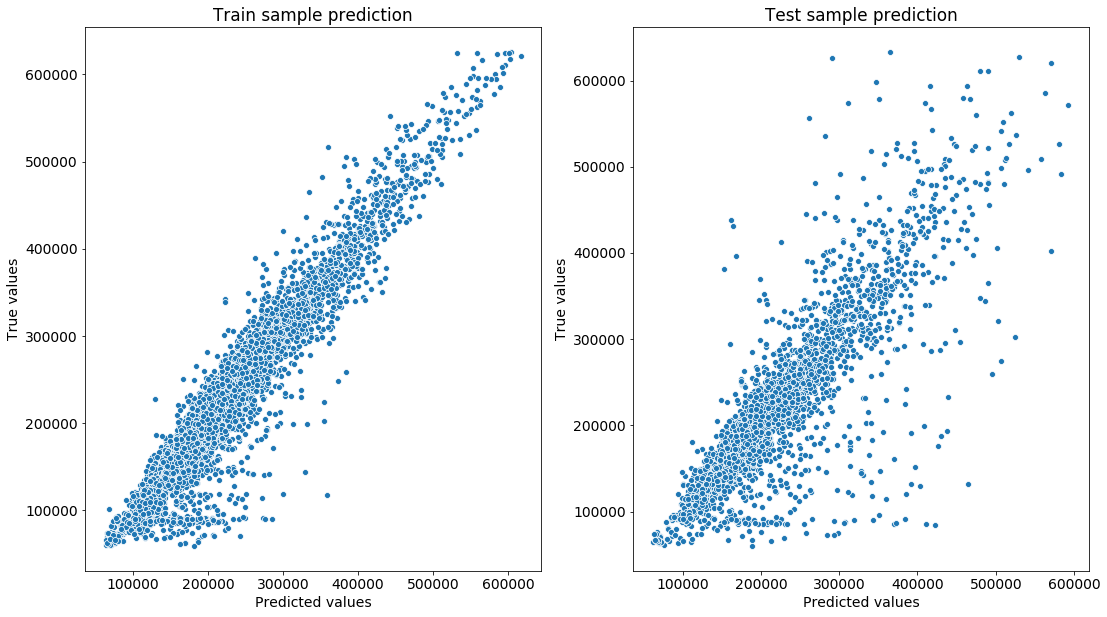

In [68]:
y_train_preds = grid.best_estimator_.predict(X_train)
y_test_preds = grid.best_estimator_.predict(X_test)


evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [69]:
X_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,3300.0,1.901,0.820,1.000,1.000,2.000,3.000,5.000
Square,3300.0,56.791,22.205,1.137,41.727,53.301,66.311,604.706
LifeSquare,3300.0,35.954,17.862,1.050,25.492,32.781,42.704,410.640
KitchenSquare,3300.0,6.381,5.106,1.000,4.000,6.000,9.000,84.000
Floor,3300.0,8.592,5.283,1.000,4.000,7.000,12.000,37.000
HouseFloor,3300.0,12.532,6.720,0.000,9.000,12.000,17.000,99.000
HouseYear,3300.0,1985.192,18.235,1910.000,1974.000,1977.000,2001.000,2020.000
Ecology_1,3300.0,0.119,0.118,0.000,0.021,0.075,0.196,0.522
Ecology_2_bin,3300.0,0.993,0.081,0.000,1.000,1.000,1.000,1.000
Ecology_3_bin,3300.0,0.972,0.164,0.000,1.000,1.000,1.000,1.000


**Важность признаков**

In [70]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,3.966e-01
10,Social_1,1.109e-01
11,Social_2,7.893e-02
0,Rooms,7.560e-02
12,Social_3,5.859e-02
7,Ecology_1,4.772e-02
6,HouseYear,4.393e-02
2,LifeSquare,3.702e-02
4,Floor,3.378e-02
3,KitchenSquare,3.077e-02


# Тестовые данные test_df

In [71]:
X_exit = pd.get_dummies(test_df[feature_names])

In [72]:
#X_test.drop("Id", axis=1, inplace=True)
X_exit.shape


(5000, 17)

In [73]:
test_df["Price"] = grid.best_estimator_.predict(X_exit)

In [74]:
test_df.shape

(5000, 23)

In [75]:
test_df.loc[:, ['Id', 'Price']].to_csv('EANesterov_72261.csv', index=False)